# Experiments with `aihwkit`
## Exploring the sensitivity of analog inference, analog-aware training and in-analog training to the non-idealities of Analog Crossbars

Analog Crossbars are used to perform Vector-Matrix Multiplications (VMMs) in the dynamic memory where the matrix is stored. As such, the computation is performed in analog fashion and requires peripheral cicuitry to integrate with other modern digital computing elements. The figure below shows the general architecture of a crossbar array along with zoomed-in illustrations of the synaptic device and ADC circuitry.

| ![Crossbar architecture](imgs/xbar.png) |
|:--:| 
| **(a) General Architecture of a Crossbar array with illustrations of (b) synaptic device and (c) ADC circuitry** (Reference: https://www.researchgate.net/publication/328091629_Memristor-based_Deep_Convolution_Neural_Network_A_Case_Study) |

One of the fundamental operations in the evaluation of neural networks is the VMM operation, where vectors of activations are to be multiplied with arrays of weights. In analog crossbar implementations, the arrays of weights are programmed into memories and the vectors of activations are presented along the wordlines after being converted into analog values by arrays of DACs. Once the multiplication is carried out in the analog domain, which takes a single cycle, the sum-of-products produced on the bitlines are converted into digital values using ADCs for further propagation down the network. These peripheral circuits introduce non-idealitites and tradeoffs that impact the performance of crossbar implementations. The weights are stored in synaptic devices called Resistive Processing Units (RPUs), which model analog memory cells. An array of RPUs make up an Analog Tile in the toolkit. The choice of the synaptic device from a variety of memory cell types also introduce non-idealities and tradeoffs that impact the performance of crossbar implementations.

This notebook studies the sensitivity of a crossbar implementation of a LeNet5 network trained on the MNIST task to a list of non-idealities introduced by the peripheral circuits and choice of synaptic device.


The first thing to do is to install the AIHKIT and dependencies in your environment. The preferred way to install this package is by using the Python package index (please uncomment this line to install in your environment if not previously installed):

In [ ]:
# To install the cpu-only enabled kit, uncommend the line below
#pip install aihwkit

# To install the gpu enabled wheel, use the commands below

!wget https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.4.5-cp37-cp37m-manylinux2014_x86_64.whl
!pip install aihwkit-0.4.5-cp37-cp37m-manylinux2014_x86_64.whl

If the library was installed correctly, you can use the following snippet for creating an analog layer and predicting the output:

In [ ]:
from torch import Tensor
from aihwkit.nn import AnalogLinear

model = AnalogLinear(2, 2)
model(Tensor([[0.1, 0.2], [0.3, 0.4]]))

Now that the package is installed and running, we can start with the experiments. We begin by importing the necessary libraries, defining the global settings and hyperparameters and defining the helper functions required for our experiments.

In [1]:
# Imports and Helper Functions

%matplotlib notebook
import os
from datetime import datetime
from IPython.display import display, clear_output
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np

# Imports from PyTorch.
import torch
from torch import nn
from torchvision import datasets, transforms

# Imports from aihwkit.
from aihwkit.nn import AnalogConv2d, AnalogLinear, AnalogSequential
from aihwkit.nn.conversion import convert_to_analog
from aihwkit.optim import AnalogSGD
from torch.optim import SGD
from aihwkit.simulator.configs import FloatingPointRPUConfig, SingleRPUConfig, UnitCellRPUConfig, InferenceRPUConfig, DigitalRankUpdateRPUConfig
from aihwkit.simulator.configs.devices import *
from aihwkit.simulator.rpu_base import cuda

gpu = torch.device('cuda')
plt.style.use('ggplot')

# Path to store datasets
PATH_DATASET = os.path.join('data', 'DATASET')

# Training parameters
SEED = 1
N_EPOCHS = 5
BATCH_SIZE = 8
LEARNING_RATE = 0.01
N_CLASSES = 10


def load_images(bs):
    """Load images for train from torchvision datasets.
    
    Args:
        bs (int): batchsize
    """

    transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.MNIST(PATH_DATASET, download=True, train=True, transform=transform)
    val_set = datasets.MNIST(PATH_DATASET, download=True, train=False, transform=transform)
    train_data = torch.utils.data.DataLoader(train_set, batch_size=bs, shuffle=True)
    validation_data = torch.utils.data.DataLoader(val_set, batch_size=bs, shuffle=False)

    return train_data, validation_data

def create_digital_optimizer(model, learning_rate):
    """Create the conventional "digital" optimizer.

    Args:
        model (nn.Module): model to be trained
        learning_rate (float): global parameter to define learning rate

    Returns:
        nn.Module: SGD optimizer
    """
    optimizer = SGD(model.parameters(), lr=learning_rate)
    
    return optimizer

def create_analog_optimizer(model, learning_rate):
    """Create the analog-aware optimizer.

    Args:
        model (nn.Module): model to be trained
        learning_rate (float): global parameter to define learning rate

    Returns:
        nn.Module: Analog optimizer
    """
    optimizer = AnalogSGD(model.parameters(), lr=learning_rate)
    optimizer.regroup_param_groups(model)

    return optimizer


def train_step(train_data, model, criterion, optimizer):
    """Train network.

    Args:
        train_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer

    Returns:
        nn.Module, nn.Module, float:  model, optimizer and loss for per epoch
    """
    total_loss = 0

    model.train()

    for images, labels in train_data:
        images = images.to(gpu)
        labels = labels.to(gpu)
        optimizer.zero_grad()

        # Add training Tensor to the model (input).
        output = model(images)
        loss = criterion(output, labels)

        # Run training (backward propagation).
        loss.backward()

        # Optimize weights.
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    epoch_loss = total_loss / len(train_data.dataset)

    return model, optimizer, epoch_loss


def test_evaluation(validation_data, model, criterion):
    """Test trained network.

    Args:
        validation_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss

    Returns:
        nn.Module, float, float, float:  model, loss, error, and accuracy
    """
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in validation_data:
        images = images.to(gpu)
        labels = labels.to(gpu)

        pred = model(images)
        loss = criterion(pred, labels)
        total_loss += loss.item() * images.size(0)

        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()
        accuracy = predicted_ok/total_images*100
        error = (1-predicted_ok/total_images)*100

    epoch_loss = total_loss / len(validation_data.dataset)

    return model, epoch_loss, error, accuracy


def training_loop(model, criterion, optimizer, train_data, validation_data, epochs, fig, print_every=1):
    """Training loop.

    Args:
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer
        train_data (DataLoader): Validation set to perform the evaluation
        validation_data (DataLoader): Validation set to perform the evaluation
        epochs (int): global parameter to define epochs number
        print_every (int): defines how many times to print training progress

    Returns:
        nn.Module, Optimizer, Tuple: model, optimizer,
            and a tuple of train losses, validation losses, and test
            error
    """
    train_losses = []
    valid_losses = []
    test_error = []

    # Train model
    for epoch in range(0, epochs):
        # Train_step
        model, optimizer, train_loss = train_step(train_data, model, criterion, optimizer)
        train_losses.append(train_loss)

        # Validate_step
        with torch.no_grad():
            model, valid_loss, error, accuracy = test_evaluation(
                validation_data, model, criterion)
            valid_losses.append(valid_loss)
            test_error.append(error)
            
        plt.clf()
        plt.gca().set_prop_cycle(None)
        plt.plot(range(1, epoch+2), train_losses, marker="o", label="Training")
        plt.plot(range(1, epoch+2), valid_losses, marker="o", label="Validation")
        plt.gca().set_prop_cycle(None)
        plt.plot(epoch+1, train_losses[-1], marker="o", markersize=10)
        plt.plot(epoch+1, valid_losses[-1], marker="o", markersize=10)
        plt.xlim([0.5, epochs+0.5])
        plt.ylim([0, max(train_losses)+0.25])
        plt.xticks(range(1, epochs+2))
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        fig.canvas.draw()

    return model, optimizer, (train_losses, valid_losses, test_error)

def create_analog_network(rpu_config):
    """Return a LeNet5 inspired analog model."""
    channel = [16, 32, 512, 128]
    model = AnalogSequential(
        AnalogConv2d(in_channels=1, out_channels=channel[0], kernel_size=5, stride=1,
                     rpu_config=rpu_config),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        AnalogConv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=5, stride=1,
                     rpu_config=rpu_config),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        nn.Tanh(),
        nn.Flatten(),
        AnalogLinear(in_features=channel[2], out_features=channel[3], rpu_config=rpu_config),
        nn.Tanh(),
        AnalogLinear(in_features=channel[3], out_features=N_CLASSES, rpu_config=rpu_config),
        nn.LogSoftmax(dim=1)
    )

    return model



## Baseline : Training Digital LeNet5

We begin by defining and training a conventional "digital" LeNet5 network on the MNIST task, which will act as the accuracy baseline for our experiments with analog inference, tuning and training.

In [2]:
epochss = widgets.IntSlider(value=5, min=1, max=30, step=1, description='Epochs:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
batchsizes = widgets.IntSlider(value=100, min=10, max=100, step=10, description='Batchsize:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
display(epochss)
display(batchsizes)

IntSlider(value=5, continuous_update=False, description='Epochs:', max=30, min=1)

IntSlider(value=100, continuous_update=False, description='Batchsize:', min=10, step=10)

<IPython.core.display.Javascript object>


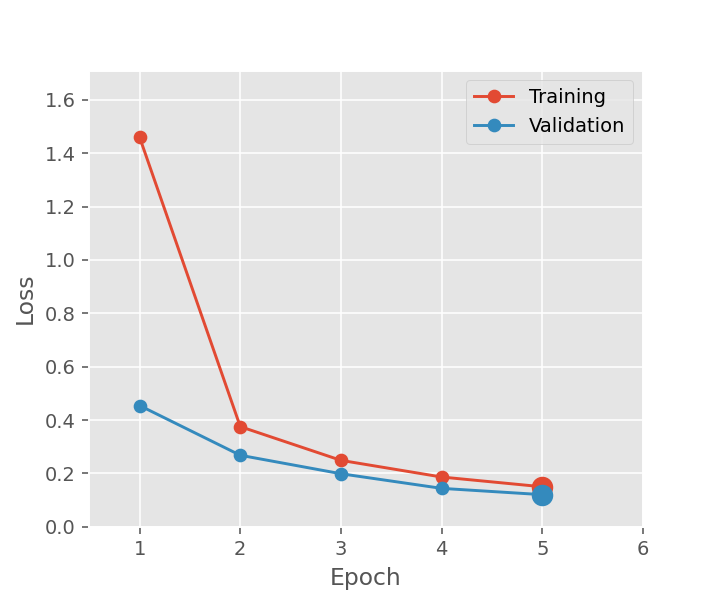

In [3]:
epochs = epochss.value
batchsize = batchsizes.value
def create_digital_network():
    channel = [16, 32, 512, 128]
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=channel[0], kernel_size=5, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=5, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=channel[2], out_features=channel[3]),
        nn.ReLU(),
        nn.Linear(in_features=channel[3], out_features=N_CLASSES),
        nn.LogSoftmax(dim=1)
    )

    return model


train_data, validation_data = load_images(batchsize)

# Prepare the model.
dmodel = create_digital_network()
dmodel.to(gpu)

optimizer = create_digital_optimizer(dmodel, LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

fig = plt.figure(figsize=(5, 4), dpi=150)
dmodel, optimizer, _ = training_loop(dmodel, criterion, optimizer, train_data, validation_data, epochs, fig)



In [4]:
dmodel, _, _, digital_accuracy = test_evaluation(validation_data, dmodel, criterion)
print(f"Accuracy of the digital model: {digital_accuracy:.2f}%")

Accuracy of the digital model: 96.29%


## Experiment 1 : Analog Inference

As a preliminary experiment, we perform "analog" inference of the previously trained digital LeNet with floating point synaptic device model, while ignoring the non-idealities of peripheral circuits discussed earlier. 

In [5]:
rpu_config = FloatingPointRPUConfig(device=FloatingPointDevice())
amodel = convert_to_analog(dmodel, rpu_config)
print(amodel)

AnalogSequential(
  (0): AnalogConv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), digital bias)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): AnalogConv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), digital bias)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): AnalogLinear(in_features=512, out_features=128, bias=True, digital bias)
  (9): ReLU()
  (10): AnalogLinear(in_features=128, out_features=10, bias=True, digital bias)
  (11): LogSoftmax(dim=1)
)


In [6]:
amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
print(f"Accuracy of the analog model: {accuracy:.2f}%")
print(f"Accuracy degradation: {digital_accuracy-accuracy:.2f}%")

Accuracy of the analog model: 96.29%
Accuracy degradation: 0.00%


## Experiment 2 : Parameters of Analog Inference

In this experiment, we introduce a few of the non-idealities involved in analog inference. Experimenting with different settings for these factors shows the clear impact on performance due to analog inference.

In [7]:
devices = widgets.Dropdown(
    options=['FloatingPointDevice', 'ConstantStepDevice', 'LinearStepDevice', 'IdealDevice', 'PulsedDevice', 'UnitCell', 'DigitalRankUpdateCell'],
    value='FloatingPointDevice',
    description='Device:',
    disabled=False,
)
configs = widgets.Dropdown(
    options=['FloatingPointRPUConfig', 'SingleRPUConfig', 'UnitCellRPUConfig', 'InferenceRPUConfig', 'DigitalRankUpdateRPUConfig'],
    value='FloatingPointRPUConfig',
    description='Config:',
    disabled=False,
)
DAC = widgets.SelectionSlider(options=[2**i for i in range(1, 11)], value=2**6, description='DAC steps:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)
DACRnd = widgets.Checkbox(value=False, description='Stochastic Rounding', disabled=False, indent=False)
DACns = widgets.FloatSlider(value=0, min=0, max=1, step=.01, description='DAC noise:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f')
ADC = widgets.SelectionSlider(options=[2**i for i in range(1, 11)], value=2**6, description='ADC steps:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)
ADCRnd = widgets.Checkbox(value=False, description='Stochastic Rounding', disabled=False, indent=False)
ADCns = widgets.FloatSlider(value=0, min=0, max=1, step=.01, description='ADC noise:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f')
display(devices)
display(configs)
display(widgets.HBox([DAC, DACRnd, DACns]))
display(widgets.HBox([ADC, ADCRnd, ADCns]))
deviceClasses = [FloatingPointDevice, ConstantStepDevice, LinearStepDevice, IdealDevice, PulsedDevice, UnitCell, DigitalRankUpdateCell]
configClasses = [FloatingPointRPUConfig, SingleRPUConfig, UnitCellRPUConfig, InferenceRPUConfig, DigitalRankUpdateRPUConfig]
device_map = {devices.options[i]: deviceClasses[i] for i in range(len(deviceClasses))}
config_map = {configs.options[i]: configClasses[i] for i in range(len(configClasses))}

Dropdown(description='Device:', options=('FloatingPointDevice', 'ConstantStepDevice', 'LinearStepDevice', 'Ide…

Dropdown(description='Config:', options=('FloatingPointRPUConfig', 'SingleRPUConfig', 'UnitCellRPUConfig', 'In…

In [8]:
device = device_map[devices.value]
config = config_map[configs.value]
if configs.value == 'InferenceRPUConfig':
    rpu_config = config()
else:
    rpu_config = config(device=device())
if configs.value != 'FloatingPointRPUConfig':
    rpu_config.forward.inp_res = DAC.value# if DAC.value > 0 else -1
    rpu_config.forward.inp_sto_round = DACRnd.value
    rpu_config.forward.inp_noise = DACns.value
    rpu_config.forward.out_res = ADC.value# if DAC.value > 0 else -1
    rpu_config.forward.out_sto_round = ADCRnd.value
    rpu_config.forward.out_noise = ADCns.value

amodel = convert_to_analog(dmodel, rpu_config)
amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
print(f"Accuracy of the analog model: {accuracy:.2f}%")
print(f"Accuracy degradation: {digital_accuracy-accuracy:.2f}%")

Accuracy of the analog model: 93.69%
Accuracy degradation: 2.60%


## Experiment 3 : Parameter Sweep

In this experiment, we perform sweeps of the different non-idealitiy settings introduced in the previous experiment and visualize the impact on accuracy of analog inference.

In [9]:
params = widgets.Dropdown(
    options=['DAC: steps', 'DAC: SR', 'DAC: noise', 'ADC: steps', 'ADC: SR', 'ADC: noise'],
    value='DAC: noise',
    description='Sweep:',
    disabled=False,
)
lock = widgets.Checkbox(value=False, description='Lock ADC and DAC', disabled=False, indent=False)

display(devices)
display(configs)
display(widgets.HBox([DAC, DACRnd, DACns]))
display(widgets.HBox([ADC, ADCRnd, ADCns]))
display(widgets.HBox([params, lock]))


Dropdown(description='Device:', index=1, options=('FloatingPointDevice', 'ConstantStepDevice', 'LinearStepDevi…

Dropdown(description='Config:', index=1, options=('FloatingPointRPUConfig', 'SingleRPUConfig', 'UnitCellRPUCon…

SelectionSlider(continuous_update=False, description='DAC steps:', index=9, options=(2, 4, 8, 16, 32, 64, 128,…

<IPython.core.display.Javascript object>


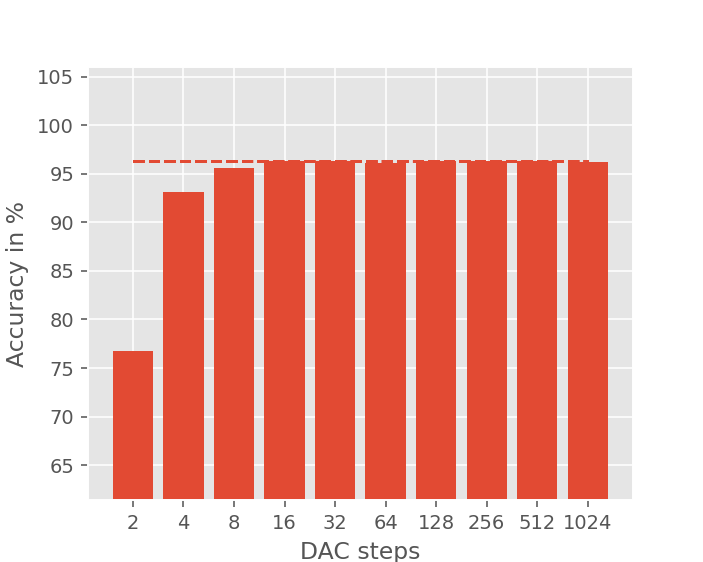

In [13]:
wdgts = [DAC, DACRnd, DACns, ADC, ADCRnd, ADCns]
wdgtsL = [ADC, ADCRnd, ADCns, DAC, DACRnd, DACns]
sweeps = [[2**i for i in range(1, 11)], [False, True], [i/10 for i in range(0, 11)], [2**i for i in range(1, 11)], [False, True], [i/10 for i in range(0, 11)]]
wdgt_map = {params.options[i]: wdgts[i] for i in range(len(wdgts))}
wdgtL_map = {params.options[i]: wdgtsL[i] for i in range(len(wdgts))}
sweep_map = {params.options[i]: sweeps[i] for i in range(len(sweeps))}
param = wdgt_map[params.value]
paramL = wdgtL_map[params.value]
sweep = sweep_map[params.value]
device = device_map[devices.value]
config = config_map[configs.value]

acc = np.zeros(len(sweep))
if lock.value:
    display(widgets.HBox([param, paramL]))
else:
    display(param)
fig = plt.figure(figsize=(5, 4), dpi=150)

for i in range(len(sweep)):
    val = sweep[i]
    param.value = val
    if lock.value:
        paramL.value = val
    if configs.value == 'InferenceRPUConfig':
        rpu_config = config()
    else:
        rpu_config = config(device=device())
    if configs.value != 'FloatingPointRPUConfig':
        rpu_config.forward.inp_res = DAC.value
        rpu_config.forward.inp_sto_round = DACRnd.value
        rpu_config.forward.inp_noise = DACns.value
        rpu_config.forward.out_res = ADC.value
        rpu_config.forward.out_sto_round = ADCRnd.value
        rpu_config.forward.out_noise = ADCns.value


    amodel = convert_to_analog(dmodel, rpu_config)
    amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
    acc[i] = accuracy
    plt.gca().set_prop_cycle(None)
    plt.bar([str(j) for j in sweep], acc, width=.8)
    plt.ylim([min(acc)*.8, max(acc)*1.1])
    plt.ylabel("Accuracy in %")
    plt.xlabel(param.description[:-1])
    plt.hlines(digital_accuracy, str(sweep[0]), str(sweep[-1]), linestyle="--")
    fig.canvas.draw()




## Experiment 4 : Analog-aware Tuning

In this experiment, we perform analog-aware retraining of the digital LeNet model using the inference RPU configuration with the non-idealities of the peripheral circuitry in action. This experiment shows that with analog-aware tuning, accuracy degradation caused by analog non-idealities can be minimized. Please note that with the inference RPU configuration, the backward pass is processed ideally.

In [14]:
display(widgets.HBox([DAC, DACRnd, DACns]))
display(widgets.HBox([ADC, ADCRnd, ADCns]))


In [16]:
rpu_config = InferenceRPUConfig()
rpu_config.forward.inp_res = DAC.value
rpu_config.forward.inp_sto_round = DACRnd.value
rpu_config.forward.inp_noise = DACns.value
rpu_config.forward.out_res = ADC.value
rpu_config.forward.out_sto_round = ADCRnd.value
rpu_config.forward.out_noise = ADCns.value

amodel = convert_to_analog(dmodel, rpu_config)
amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
print(f"Accuracy of the analog model: {accuracy:.2f}%")
print(f"Accuracy degradation: {digital_accuracy-accuracy:.2f}%")

display(epochss)
display(batchsizes)

Accuracy of the analog model: 83.71%
Accuracy degradation: 12.58%


IntSlider(value=5, continuous_update=False, description='Epochs:', max=30, min=1)

IntSlider(value=100, continuous_update=False, description='Batchsize:', min=10, step=10)

<IPython.core.display.Javascript object>


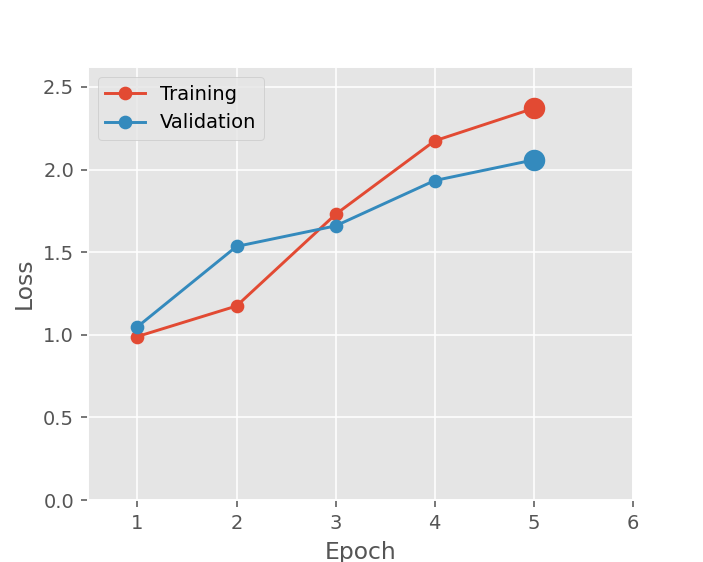

In [17]:
epochs = epochss.value
batchsize = batchsizes.value

train_data, validation_data = load_images(batchsize)
amodel = convert_to_analog(dmodel, rpu_config)
optimizer = create_analog_optimizer(amodel, LEARNING_RATE)

fig = plt.figure(figsize=(5, 4), dpi=150)
amodel, optimizer, _ = training_loop(amodel, criterion, optimizer, train_data, validation_data, epochs, fig)

In [18]:
amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
print(f"Accuracy of the analog model: {accuracy:.2f}%")
print(f"Accuracy degradation: {digital_accuracy-accuracy:.2f}%")

Accuracy of the analog model: 96.23%
Accuracy degradation: 0.06%


## Experiment 5 : in-Analog Training

In this experiment, we explore the impact of synaptic device non-idealities on inference and training processes along with the peripheral circuit non-idealities for both forward and backward passes.

In [19]:
display(devices)
display(configs)
print("Forward:")
display(widgets.HBox([DAC, DACRnd, DACns]))
display(widgets.HBox([ADC, ADCRnd, ADCns]))
print("Backward:")
bDAC = widgets.SelectionSlider(options=[2**i for i in range(1, 11)], value=2**6, description='DAC steps:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)
bDACRnd = widgets.Checkbox(value=False, description='Stochastic Rounding', disabled=False, indent=False)
bDACns = widgets.FloatSlider(value=0, min=0, max=1, step=.01, description='DAC noise:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f')
bADC = widgets.SelectionSlider(options=[2**i for i in range(1, 11)], value=2**6, description='ADC steps:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)
bADCRnd = widgets.Checkbox(value=False, description='Stochastic Rounding', disabled=False, indent=False)
bADCns = widgets.FloatSlider(value=0, min=0, max=1, step=.01, description='ADC noise:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f')
mod = widgets.SelectionSlider(options=['From digital', 'From scratch'], value='From digital', description='Model init:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)

display(widgets.HBox([bDAC, bDACRnd, bDACns]))
display(widgets.HBox([bADC, bADCRnd, bADCns]))

display(epochss)
display(batchsizes)
display(mod)

Dropdown(description='Device:', index=1, options=('FloatingPointDevice', 'ConstantStepDevice', 'LinearStepDevi…

Dropdown(description='Config:', index=1, options=('FloatingPointRPUConfig', 'SingleRPUConfig', 'UnitCellRPUCon…

Forward:


Backward:


IntSlider(value=5, continuous_update=False, description='Epochs:', max=30, min=1)

IntSlider(value=100, continuous_update=False, description='Batchsize:', min=10, step=10)

SelectionSlider(continuous_update=False, description='Model init:', options=('From digital', 'From scratch'), …

Accuracy of the analog model: 57.03%
Accuracy degradation: 39.26%


<IPython.core.display.Javascript object>


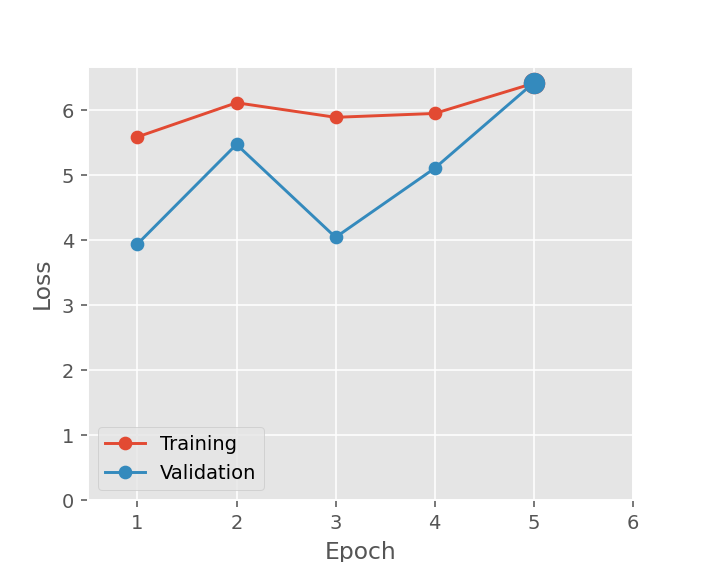

In [22]:
device = device_map[devices.value]
config = config_map[configs.value]
rpu_config = config(device=device())

rpu_config.forward.inp_res = DAC.value
rpu_config.forward.inp_sto_round = DACRnd.value
rpu_config.forward.inp_noise = DACns.value
rpu_config.forward.out_res = ADC.value
rpu_config.forward.out_sto_round = ADCRnd.value
rpu_config.forward.out_noise = ADCns.value

rpu_config.backward.inp_res = bDAC.value
rpu_config.backward.inp_sto_round = bDACRnd.value
rpu_config.backward.inp_noise = bDACns.value
rpu_config.backward.out_res = bADC.value
rpu_config.backward.out_sto_round = bADCRnd.value
rpu_config.backward.out_noise = bADCns.value

epochs = epochss.value
batchsize = batchsizes.value

train_data, validation_data = load_images(batchsize)

if mod.value == 'From digital':
    amodel = convert_to_analog(dmodel, rpu_config)
else:
    amodel = create_analog_network(rpu_config).to(gpu)

optimizer = create_analog_optimizer(amodel, LEARNING_RATE)

if mod.value == 'From digital':
    amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
    print(f"Accuracy of the analog model: {accuracy:.2f}%")
    print(f"Accuracy degradation: {digital_accuracy-accuracy:.2f}%")

fig = plt.figure(figsize=(5, 4), dpi=150)
amodel, optimizer, _ = training_loop(amodel, criterion, optimizer, train_data, validation_data, epochs, fig)

In [23]:
amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
print(f"Accuracy of the analog model: {accuracy:.2f}%")
if mod.value == 'From digital':
    print(f"Accuracy degradation: {digital_accuracy-accuracy:.2f}%")

Accuracy of the analog model: 95.36%
Accuracy degradation: 0.93%
